In [44]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [45]:
#NEW DATA TEST
caiso=pd.read_csv("/Users/john_schafer/Downloads/CE291/CAISO_zone_1_.csv")

In [46]:
#Transform Data to our format
caiso['time'] = pd.to_datetime(caiso['time'])
caiso.set_index('time', inplace=True)

# Function to reshape the data
def reshape_data(df, column):
    # Resample data to daily frequency, and apply list to convert each day's data into a list
    daily_data = df[column].resample('D').apply(list)
    # Convert lists to a DataFrame, which inherently transposes the list to columns
    return pd.DataFrame(daily_data.tolist(), index=daily_data.index)

# Creating each DataFrame
demand_df = reshape_data(caiso, 'load_power')
solar_df = reshape_data(caiso, 'solar_power')
wind_df = reshape_data(caiso, 'wind_power')

def rename_columns(df):
    num_minutes = df.shape[1]
    time_labels = [str(pd.Timedelta(minutes=i)) for i in range(num_minutes)]
    df.columns = time_labels
    return df

demand_df = rename_columns(demand_df)
solar_df = rename_columns(solar_df)
wind_df = rename_columns(wind_df)

In [47]:

#Scaling 
# if power is normalized to 1, PEV dynamics in environment are run in kw
#max power of single Ev = 11 kw 
#max power of representative small microgrid of 5,000 people ~ 3.5 megawatts=3,500 kw
#multiply vby 3500 to get representative 
demand_caiso = np.array(demand_df)
solar_caiso = np.array(solar_df)*3 
wind_caiso = np.array(wind_df)*4 
net_caiso=demand_caiso-solar_caiso-wind_caiso

average_demand_per_minute = np.nanmean(demand_caiso, axis=0)
average_solar_per_minute = np.nanmean(solar_caiso, axis=0)
average_wind_per_minute = np.nanmean(wind_caiso, axis=0)

average_net_per_minute=average_demand_per_minute-average_solar_per_minute-average_wind_per_minute

In [48]:
#Sample only every ten minutes
average_demand_10min= average_demand_per_minute[::10]
average_solar_10min= average_solar_per_minute[::10]
average_wind_10min= average_wind_per_minute[::10]

average_net_10min=average_demand_10min-average_solar_10min-average_wind_10min

average_demand_10min= average_demand_10min.reshape(144,1).T
average_solar_10min=average_solar_10min.reshape(144,1).T
average_wind_10min=average_wind_10min.reshape(144,1).T

In [49]:
demand_caiso.shape

(1096, 1440)

In [50]:
#Sample every ten minutes for all episodes
demand_10min=demand_caiso[:, ::10]
solar_10min=solar_caiso[:, ::10]
wind_10min=wind_caiso[:, ::10]

demandtest=np.nanmean(demand_10min, axis=0)
solartest=np.nanmean(solar_10min, axis=0)
windtest=np.nanmean(wind_10min, axis=0)



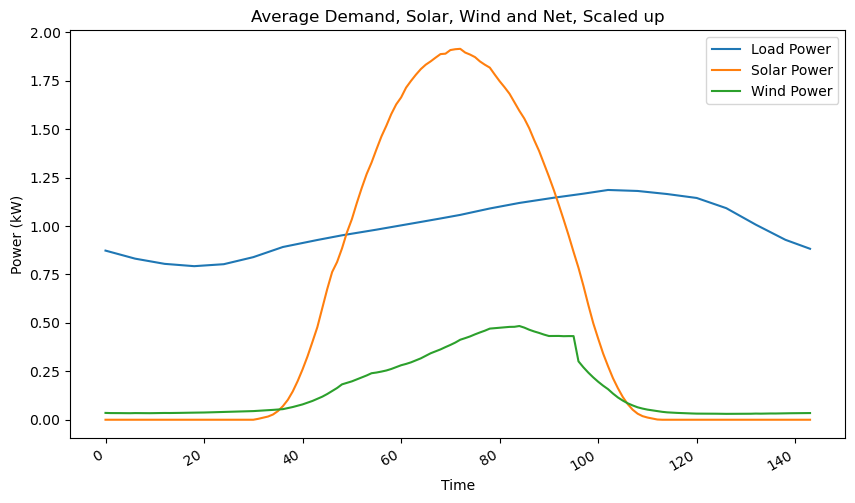

In [51]:
timestep_length=1 #in minutes
T=144 # minutes in 24hrs

time_steps = np.arange(0, T * timestep_length, timestep_length)  # Generate a time axis\
plt.figure(figsize=(10, 6))
plt.plot(time_steps, demandtest, label='Load Power')
plt.plot(time_steps, solartest, label='Solar Power')
plt.plot(time_steps, windtest, label='Wind Power')
#plt.plot(time_steps, average_net_10min, label='Net')

# Adding titles and labels
plt.title('Average Demand, Solar, Wind and Net, Scaled up')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.legend()

# Rotating date labels for better visibility
plt.gcf().autofmt_xdate()

plt.show()

In [52]:
demand_10min.shape

(1096, 144)

In [53]:
from AGENT_CRITIC import AGENT_CRITIC
from env_rnn import GridEnvironment

In [54]:
from tensorflow.keras.models import load_model

In [55]:
#Testing Max Entropy Technique
import time
timestep_length=(10/60) #in hours
N=800
sequence_length=1 #In timesteps aka minutes
state_deque = deque(maxlen=sequence_length)
day_index=400

# Load the actor model
actor_model = load_model('actor_model600.h5')

# Load the critic model
critic_model = load_model('critic_model600.h5')

# Initialize DQN agent
agent = AGENT_CRITIC(state_size=3, action_size=21, sequence_length=sequence_length, actormodel=actor_model, criticmodel=critic_model)

episode_durations = []
profiles = []

for episode in range(4):  # Loop over 3 episodes of same "average" day
    # Initialize environment for the current day
    start_time = time.time()
    env = GridEnvironment(N, demand_10min, solar_10min, wind_10min, day_index, timestep_length)
   # env = GridEnvironment(N, average_demand_10min, average_solar_10min, average_wind_10min, day_index, timestep_length)
    
    total_reward = 0
    T = 144  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)
    action_profile=np.zeros(T)

    for timestep in range(1, T + 1):
        current_demand, current_solar, current_wind, current_SoC = env.get_state()
        current_SoC = np.array(current_SoC) 
        time_array=np.array([timestep])
       # current_state = np.concatenate([np.array([current_demand, current_solar, current_wind]), current_SoC, time_array])
        current_state = np.concatenate([np.array([current_demand, current_solar, current_wind])])
    

        state_deque.append(current_state)
        state_history = np.array(state_deque)

        if len(state_deque) < sequence_length:
            continue  # Skip until we have enough data

        action = agent.act(state_history)
        reward, done, next_demand, next_solar, next_wind, next_P_EV, next_SoC = env.step(action)

        demand_profile[timestep - 1] = next_demand
        solar_profile[timestep - 1] = next_solar
        wind_profile[timestep - 1] = next_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)
        action_profile[timestep-1]=env.decode_action(action)
        
        next_SoC = np.array(next_SoC) 
        time_array_next=np.array([timestep+1])
        #next_state = np.concatenate([np.array([next_demand, next_solar, next_wind]), next_SoC, time_array_next])
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind])])

        agent.learn(state_history, action, reward, next_state, done)
        total_reward += reward

        if done:
            break
    
    print(f"Total reward for episode {episode}: {total_reward}")
    episode_durations.append(time.time() - start_time)
    day_index +=1

    profiles.append({
    'demand': demand_profile,
    'solar': solar_profile,
    'wind': wind_profile,
    'PEV': PEV_profile,
    'action': action_profile
    })

print("Individual episode durations:", episode_durations)


# Save the models
#agent.actor.save('actor_model600.h5' )
#agent.critic.save('critic_model600.h5' )

Total reward for episode 0: -35.42047502560074
Total reward for episode 1: -28.161887735950586
Total reward for episode 2: -15.187969707025903
Total reward for episode 3: -20.2181691922183
Individual episode durations: [11.812262058258057, 11.151857852935791, 10.942341089248657, 11.012969970703125]


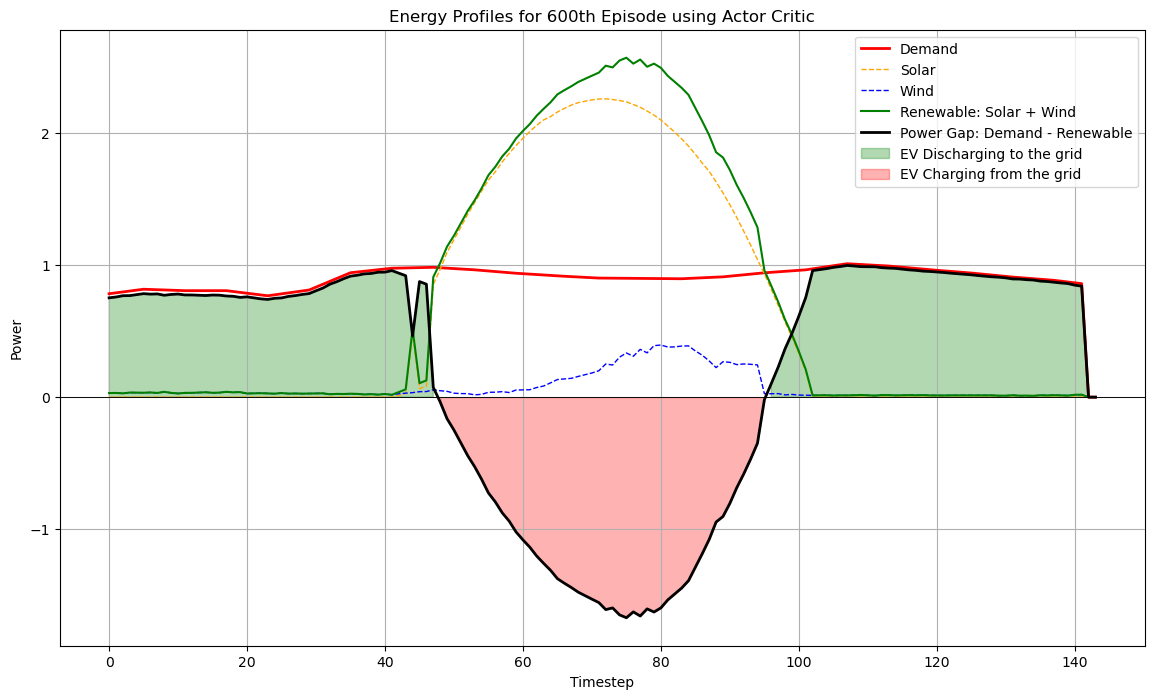

In [56]:
#PLOT
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand', color="Red",linewidth=2)

plt.plot(1*solar_profile, label='Solar', color="orange", linewidth=1, linestyle='--')
plt.plot(1*wind_profile, label='Wind', color="blue", linewidth=1,linestyle='--')
plt.plot(1*solar_profile + 1*wind_profile , label='Renewable: Solar + Wind', color='green',linewidth=1.5)

plt.plot(demand_profile-solar_profile- wind_profile, label='Power Gap: Demand - Renewable',color="Black",linewidth=2)

# Plot the PEV_profile as a bar graph
timesteps = np.arange(len(PEV_profile))  
plt.fill_between(range(len(demand_profile)), demand_profile - solar_profile - wind_profile, color='green', where=(demand_profile - solar_profile - wind_profile) >= 0, alpha=0.3, label="EV Discharging to the grid")
plt.fill_between(range(len(demand_profile)), demand_profile - solar_profile - wind_profile, color='red', where=(demand_profile - solar_profile - wind_profile) < 0, alpha=0.3, label="EV Charging from the grid")



plt.axhline(0, color='black', linewidth=0.5)


plt.axhline(0, color='black', linewidth=0.5)
plt.grid()
plt.legend()
plt.title('Energy Profiles for 600th Episode using Actor Critic')
plt.xlabel('Timestep')
plt.ylabel('Power')
plt.show()

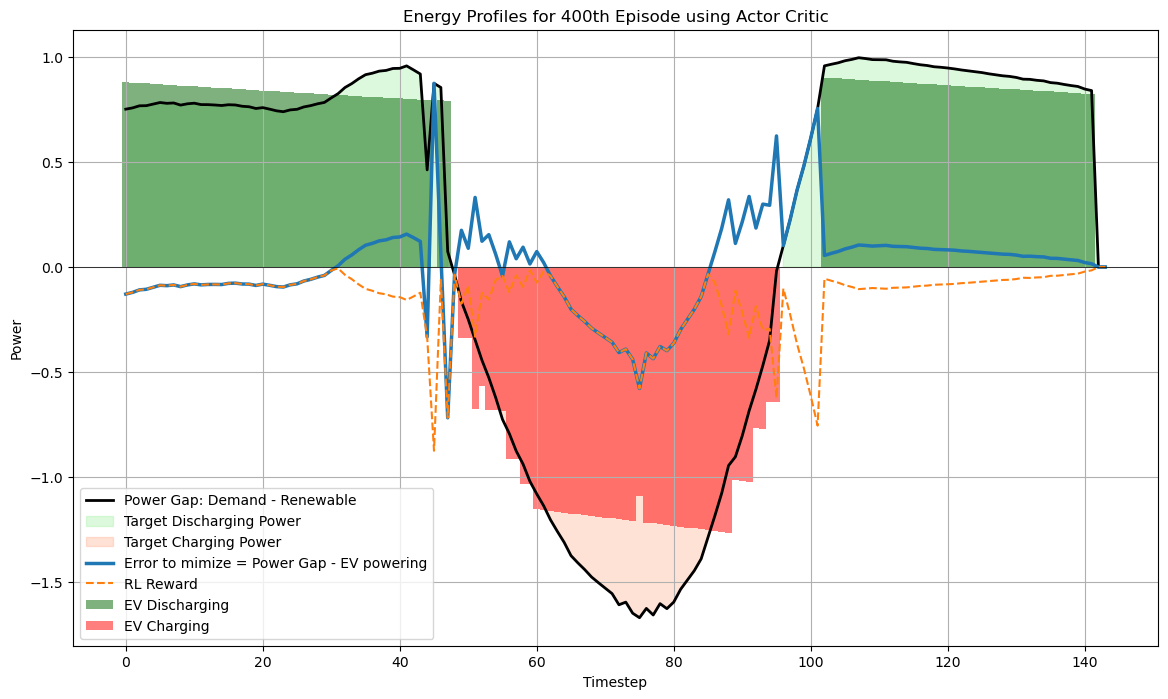

In [57]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile-solar_profile- wind_profile, label='Power Gap: Demand - Renewable',color="Black",linewidth=2)

plt.fill_between(range(len(demand_profile)), demand_profile - solar_profile - wind_profile, color='#90EE90', where=(demand_profile - solar_profile - wind_profile) >= 0, alpha=0.3, label="Target Discharging Power ")
plt.fill_between(range(len(demand_profile)), demand_profile - solar_profile - wind_profile, color='#FFA07A', where=(demand_profile - solar_profile - wind_profile) < 0, alpha=0.3, label="Target Charging Power")

#plt.plot(demand_profile, label='Demand', color="Black",linewidth=2.5)
#plt.plot(1*solar_profile + 1*wind_profile , label='Renewable: Solar + Wind', color='green',linewidth=1)



# Plot the PEV_profile as a bar graph
timesteps = np.arange(len(PEV_profile))  
#plt.bar(timesteps, -PEV_profile, width=1.0,where=-PEV_profile >=0,color='green',label='EV Discharging', alpha=0.5)  
#plt.bar(timesteps, -PEV_profile, width=1.0,where=-PEV_profile >=0,color='red' label='EV Charging', alpha=0.5)  
# Filter data for EV discharging and EV charging
discharging_profile = np.where(-PEV_profile >= 0, -PEV_profile, 0)
charging_profile = np.where(-PEV_profile < 0, -PEV_profile, 0)

# Plot bars for EV discharging
plt.bar(timesteps, discharging_profile, width=1.0, color='#006400', alpha=0.5, label='EV Discharging')

# Plot bars for EV charging
plt.bar(timesteps, charging_profile, width=1.0, color='red', alpha=0.5, label='EV Charging')

plt.plot(demand_profile+PEV_profile -solar_profile- wind_profile, label='Error to mimize = Power Gap - EV powering', linewidth=2.5)
plt.plot(-abs(demand_profile+PEV_profile -solar_profile- wind_profile), label='RL Reward', linestyle="--")



plt.axhline(0, color='black', linewidth=0.5)
plt.grid()
plt.legend()
plt.title('Energy Profiles for 400th Episode using Actor Critic')
plt.xlabel('Timestep')
plt.ylabel('Power')
plt.show()

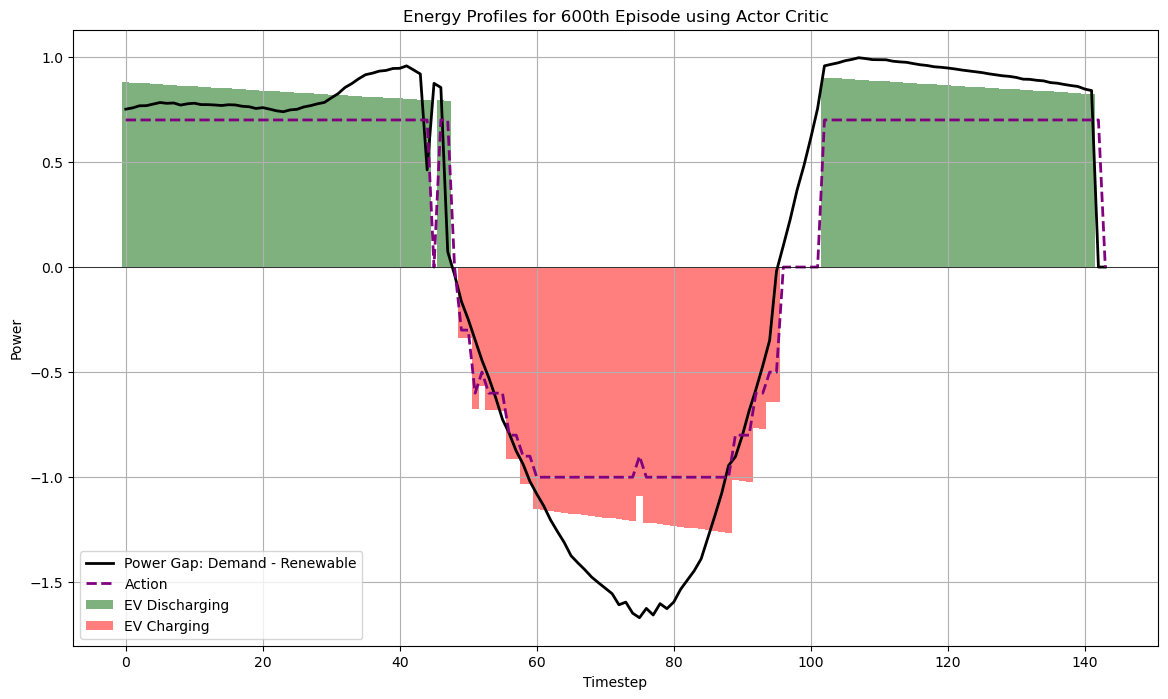

In [58]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile-solar_profile- wind_profile, label='Power Gap: Demand - Renewable',color="Black",linewidth=2)



# Plot the PEV_profile as a bar graph
timesteps = np.arange(len(PEV_profile))  

 
# Filter data for EV discharging and EV charging
discharging_profile = np.where(-PEV_profile >= 0, -PEV_profile, 0)
charging_profile = np.where(-PEV_profile < 0, -PEV_profile, 0)

# Plot bars for EV discharging
plt.bar(timesteps, discharging_profile, width=1.0, color='#006400', alpha=0.5, label='EV Discharging')

# Plot bars for EV charging
plt.bar(timesteps, charging_profile, width=1.0, color='red', alpha=0.5, label='EV Charging')

#plt.plot(demand_profile+PEV_profile -solar_profile- wind_profile, label='Error to mimize = Power Gap - EV powering', linewidth=2.5)



# Plot the action profile
plt.plot(timesteps, -action_profile, label='Action', color='purple', linestyle='--', linewidth=2)

plt.axhline(0, color='black', linewidth=0.5)
plt.grid()
plt.legend()
plt.title('Energy Profiles for 600th Episode using Actor Critic')
plt.xlabel('Timestep')
plt.ylabel('Power')
plt.show()

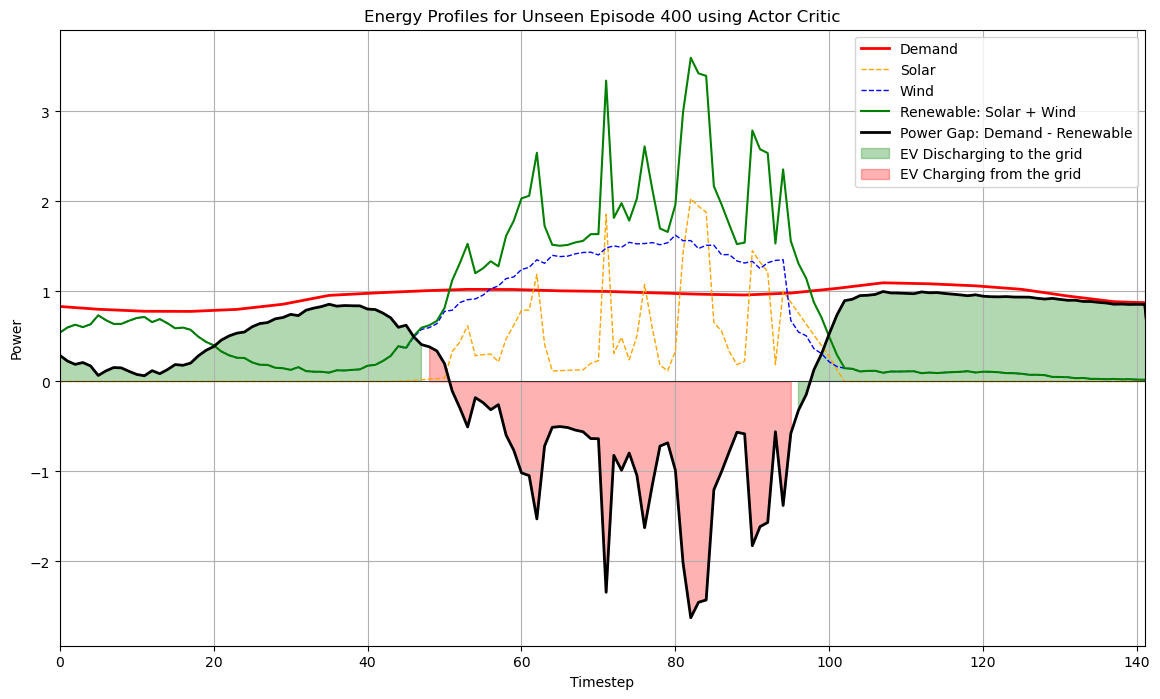

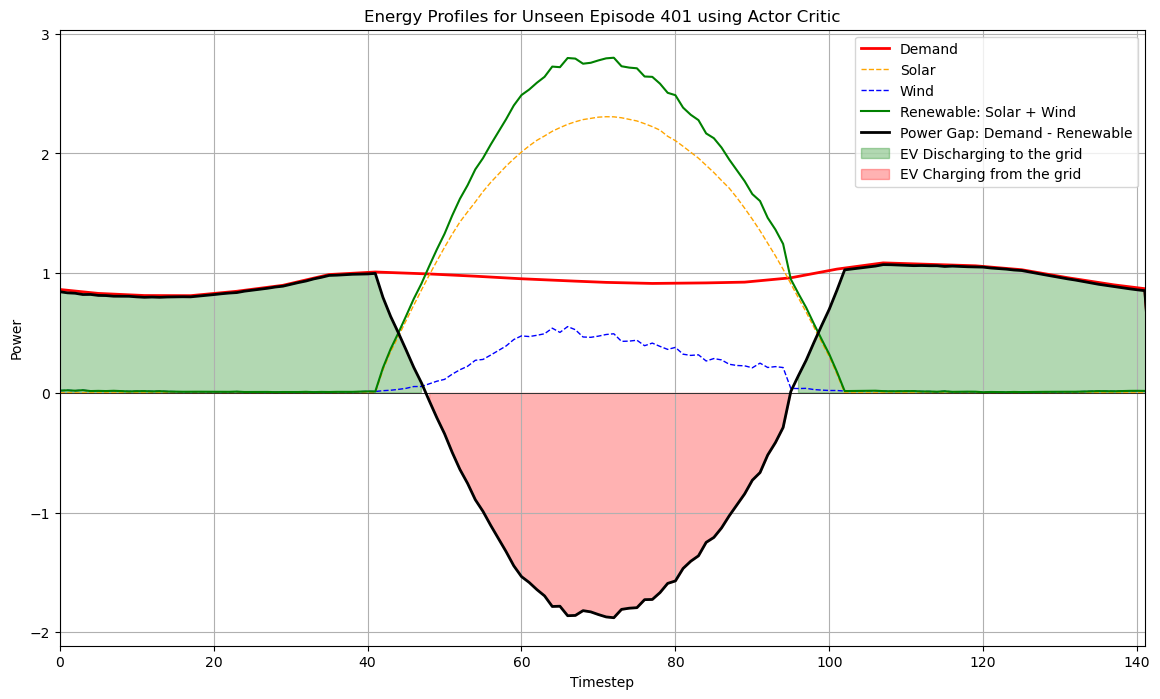

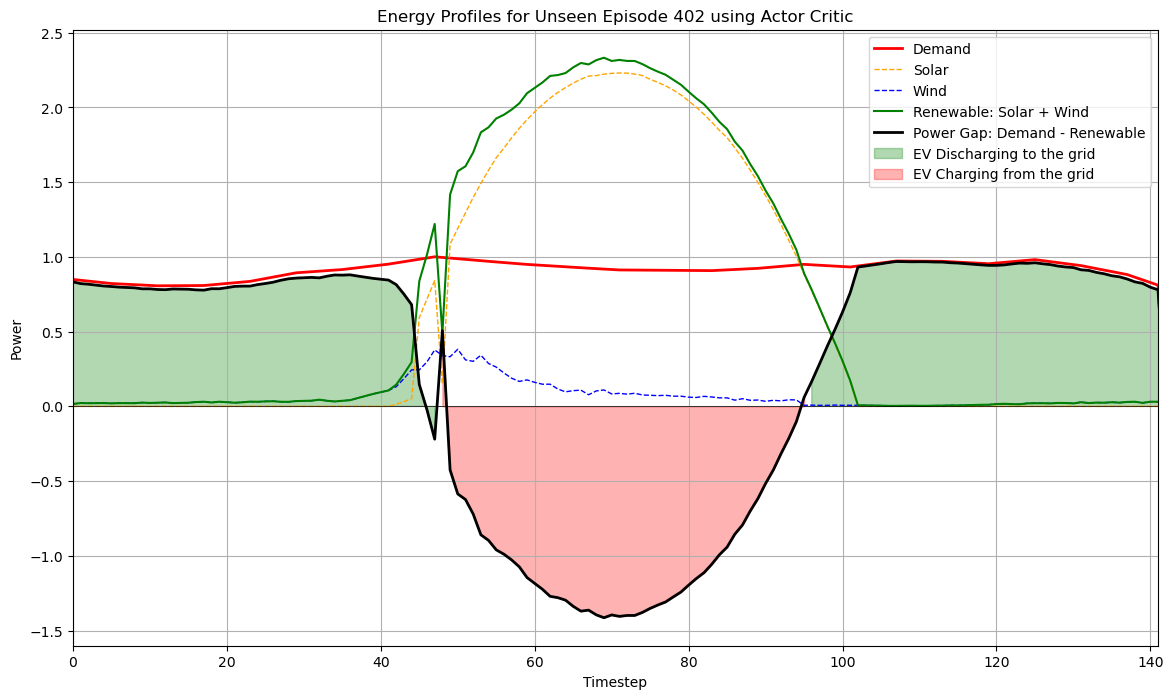

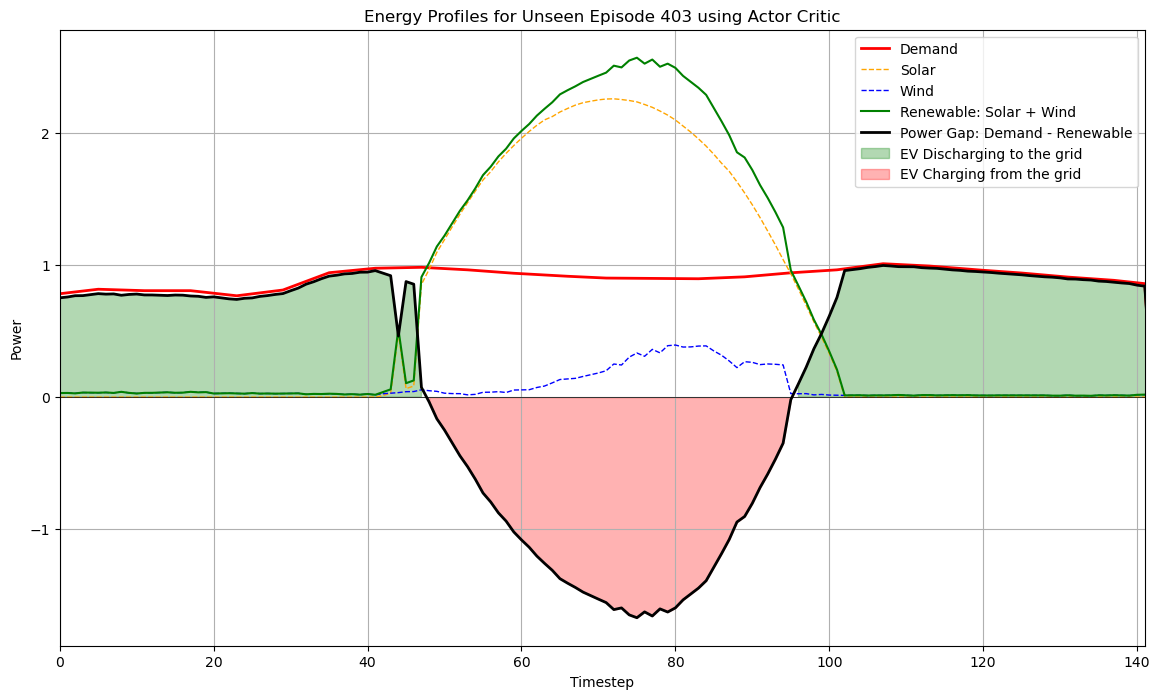

In [59]:
#Plot Each Episode
for i, profile in enumerate(profiles):
    plt.figure(figsize=(14, 8))
    plt.plot(profile['demand'], label='Demand', color="Red",linewidth=2)


    plt.plot(profile['solar'], label='Solar', color="orange", linewidth=1, linestyle='--')
    plt.plot(profile['wind'], label='Wind', color="blue", linewidth=1,linestyle='--')
    plt.plot(profile['solar'] + profile['wind'] , label='Renewable: Solar + Wind', color='green',linewidth=1.5)

    plt.plot(profile['demand']-profile['solar']- profile['wind'], label='Power Gap: Demand - Renewable',color="Black",linewidth=2)

    # Plot the PEV_profile as a bar graph
    timesteps = np.arange(len(PEV_profile))  
    plt.fill_between(range(len(profile['demand'])), profile['demand'] -profile['solar']- profile['wind'], color='green', where=(demand_profile - solar_profile - wind_profile) >= 0, alpha=0.3, label="EV Discharging to the grid")
    plt.fill_between(range(len(profile['demand'])), profile['demand'] -profile['solar']- profile['wind'], color='red', where=(demand_profile - solar_profile - wind_profile) < 0, alpha=0.3, label="EV Charging from the grid")




    plt.xlim(0, len(demand_profile)-3)
    plt.axhline(0, color='black', linewidth=0.5)
    #plt.ylim(-0.01,0.01)


    plt.grid()
    plt.legend()
    plt.title(f'Energy Profiles for Unseen Episode {i+400} using Actor Critic')
    plt.xlabel('Timestep')
    plt.ylabel('Power')
    plt.show()

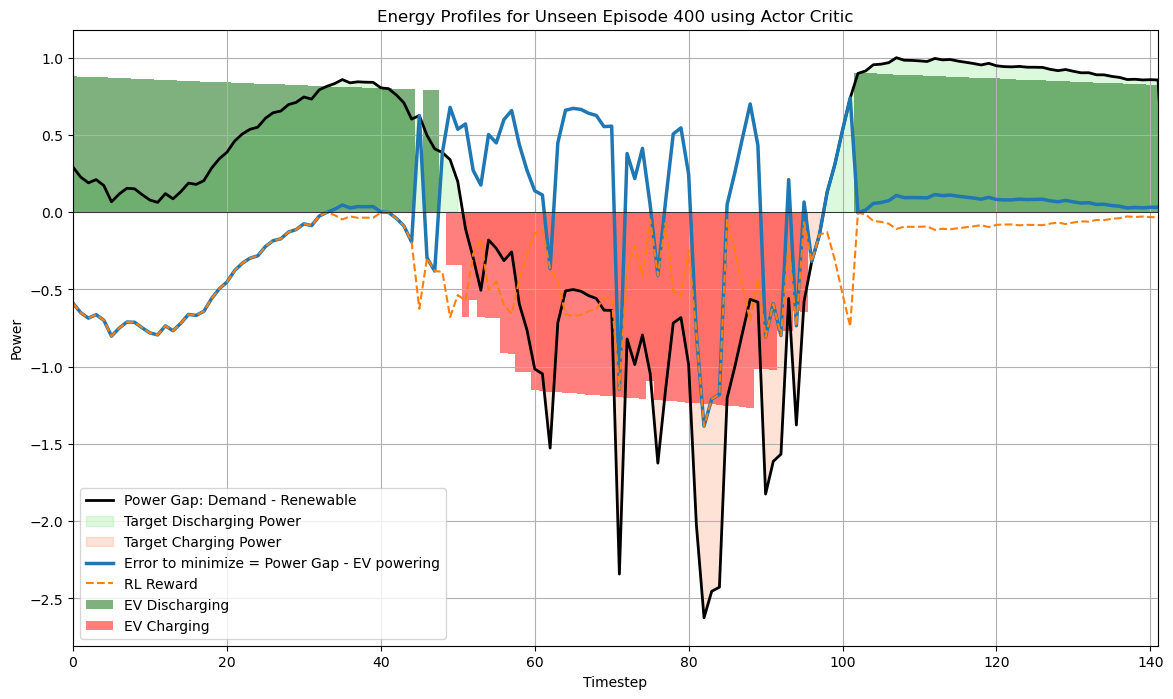

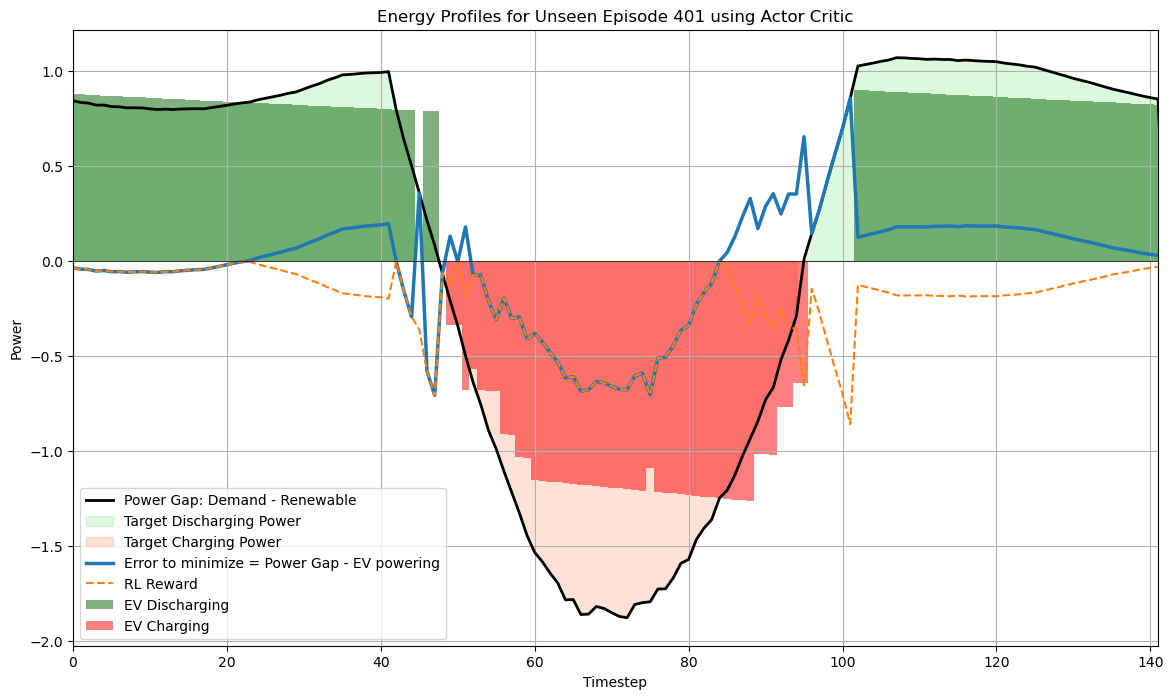

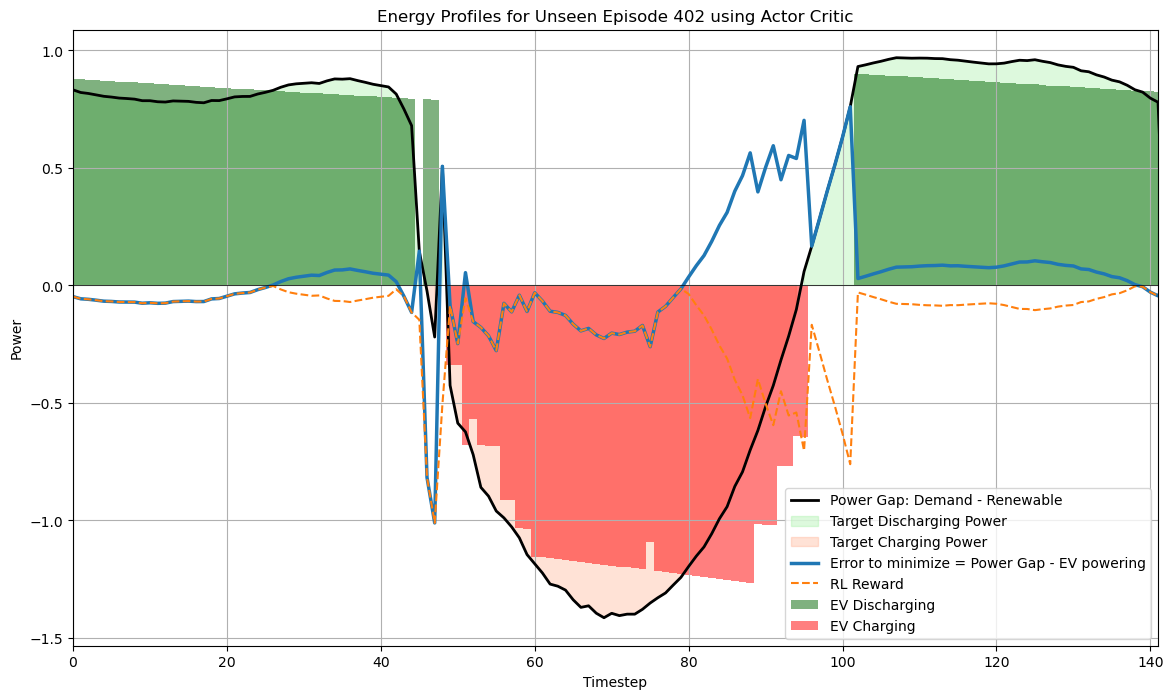

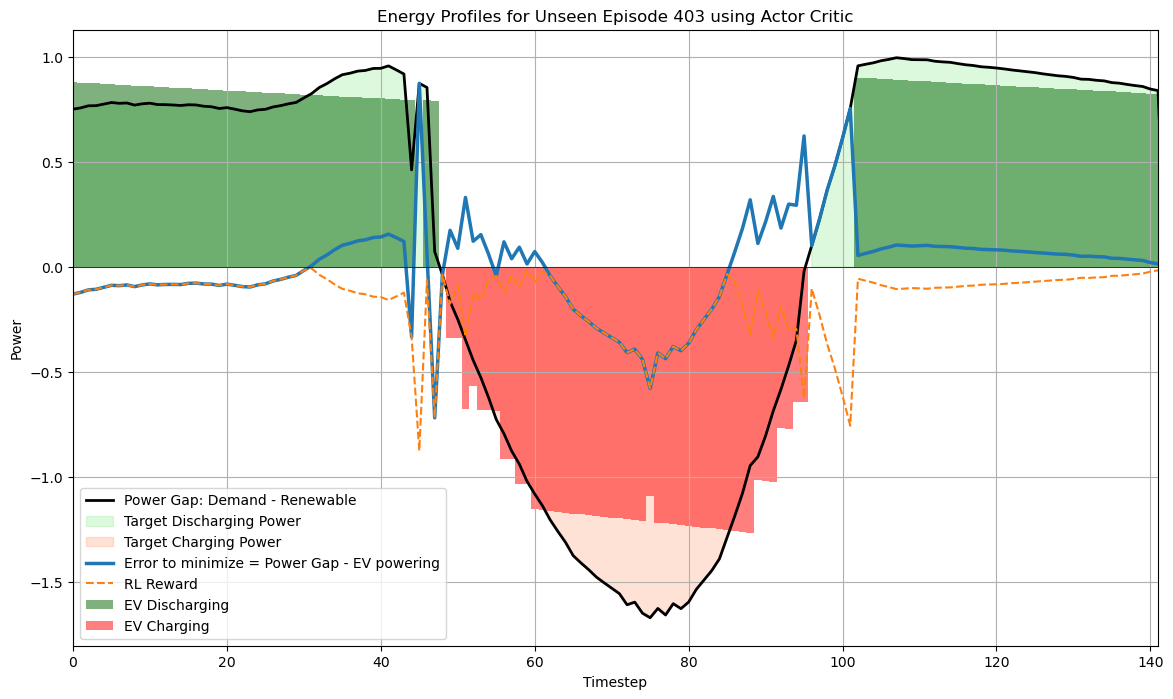

In [60]:
# Plot Each Episode
for i, profile in enumerate(profiles):
    plt.figure(figsize=(14, 8))
    plt.plot(profile['demand'] - profile['solar'] - profile['wind'], label='Power Gap: Demand - Renewable', color="Black", linewidth=2)

    plt.fill_between(range(len(profile['demand'])), profile['demand'] - profile['solar'] - profile['wind'], color='#90EE90', where=(profile['demand'] - profile['solar'] - profile['wind']) >= 0, alpha=0.3, label="Target Discharging Power ")
    plt.fill_between(range(len(profile['demand'])), profile['demand'] - profile['solar'] - profile['wind'], color='#FFA07A', where=(profile['demand'] - profile['solar'] - profile['wind']) < 0, alpha=0.3, label="Target Charging Power")

    # Filter data for EV discharging and EV charging
    discharging_profile = np.where(-PEV_profile >= 0, -PEV_profile, 0)
    charging_profile = np.where(-PEV_profile < 0, -PEV_profile, 0)

    # Plot bars for EV discharging
    plt.bar(timesteps, discharging_profile, width=1.0, color='#006400', alpha=0.5, label='EV Discharging')

    # Plot bars for EV charging
    plt.bar(timesteps, charging_profile, width=1.0, color='red', alpha=0.5, label='EV Charging')

    plt.plot(profile['demand'] + PEV_profile - profile['solar'] - profile['wind'], label='Error to minimize = Power Gap - EV powering', linewidth=2.5)
    plt.plot(-abs(profile['demand'] + PEV_profile - profile['solar'] - profile['wind']), label='RL Reward', linestyle="--")

    plt.xlim(0, len(profile['demand']) - 3)

    plt.axhline(0, color='black', linewidth=0.5)
    plt.grid()
    plt.legend()
    plt.title(f'Energy Profiles for Unseen Episode {i+400} using Actor Critic')
    plt.xlabel('Timestep')
    plt.ylabel('Power')
    plt.show()

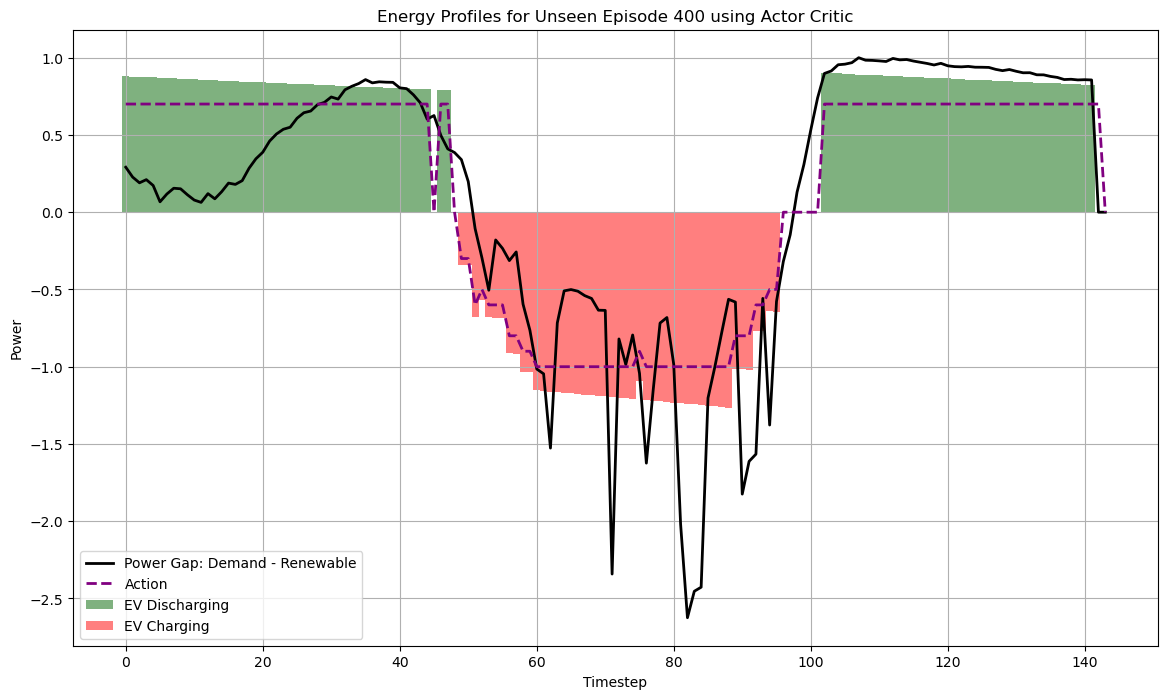

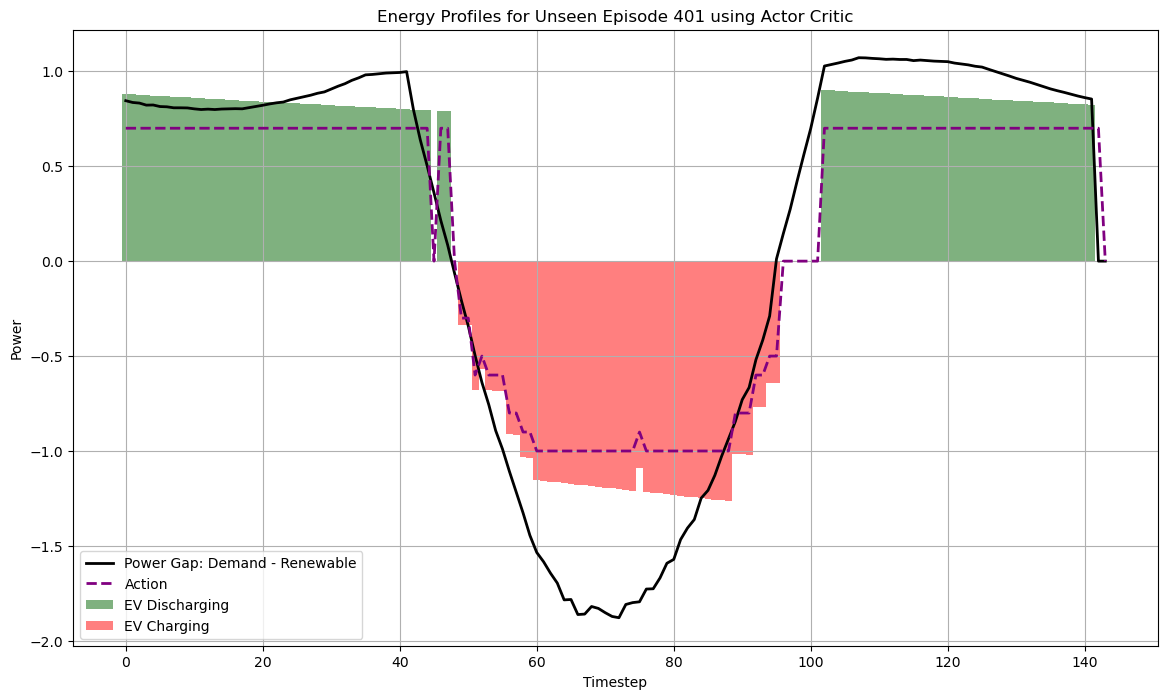

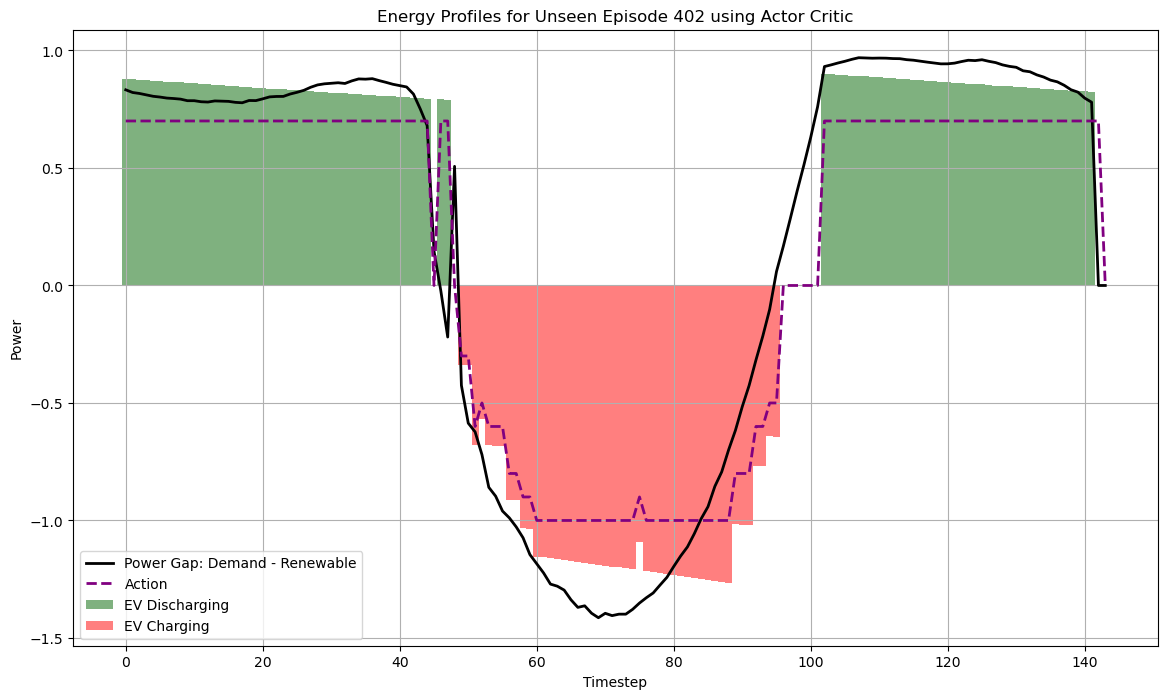

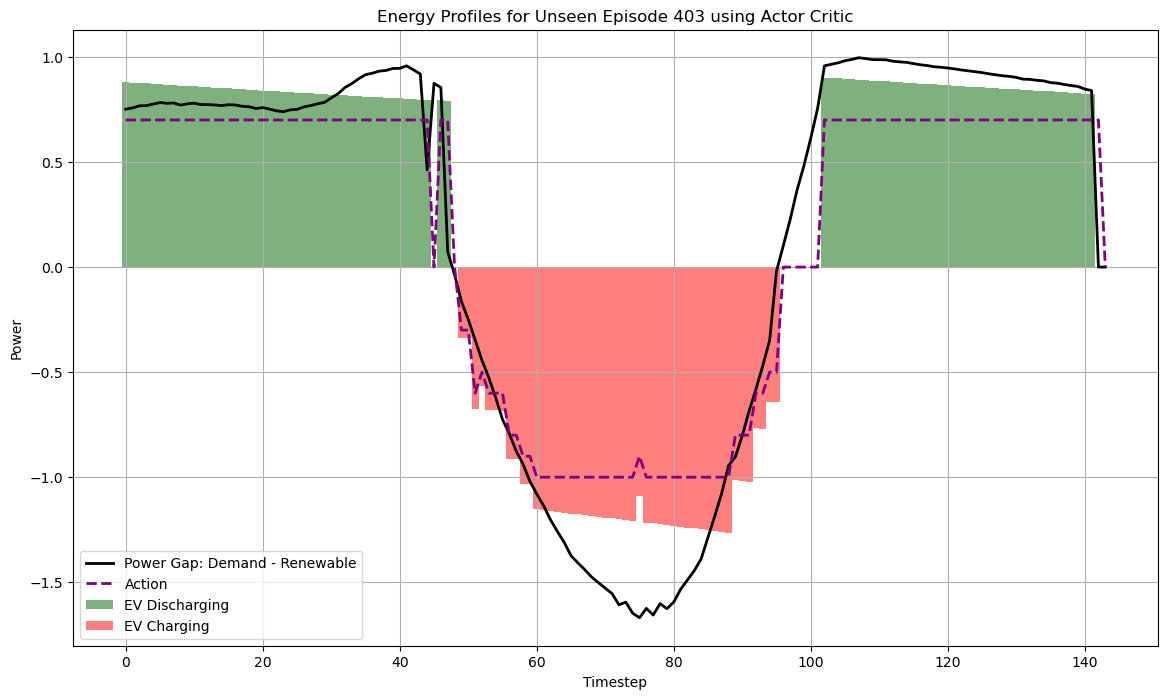

In [61]:
for i, profile in enumerate(profiles):

   plt.figure(figsize=(14, 8))
   plt.plot(profile['demand'] - profile['solar'] - profile['wind'], label='Power Gap: Demand - Renewable', color="Black", linewidth=2)

   # Plot the PEV_profile as a bar graph
   timesteps = np.arange(len(PEV_profile))  

   # Filter data for EV discharging and EV charging
   discharging_profile = np.where(-PEV_profile >= 0, -PEV_profile, 0)
   charging_profile = np.where(-PEV_profile < 0, -PEV_profile, 0)

   # Plot bars for EV discharging
   plt.bar(timesteps, discharging_profile, width=1.0, color='#006400', alpha=0.5, label='EV Discharging')

   # Plot bars for EV charging
   plt.bar(timesteps, charging_profile, width=1.0, color='red', alpha=0.5, label='EV Charging')

   # Plot the action profile
   plt.plot(timesteps, -action_profile, label='Action', color='purple', linestyle='--', linewidth=2)
   plt.grid()
   plt.legend()
   plt.title(f'Energy Profiles for Unseen Episode {i+400} using Actor Critic')
   plt.xlabel('Timestep')
   plt.ylabel('Power')
   plt.show()